# Portfolio Allocation using PCA

PCA reduces the dimensionalty of dataset with large number of variables, which retaining as much variance in data as possible, allowing us to understand if there is a different represenatation of data that can explain the majority of original data points.

PCA will find a new of new variables (also called the prinicipal components or eigenvectors) that yields the original variables. These principal components are independent and can represent the original data. The decline in the amount of variance explained by each principal component reflects the extent of correlation among the original features.

There are two approaches to finding the principal components: Eigen decompostition and Singular value decomposition (SVD)
- Eigen decompostion: Covariance matrix created for features and eigenvectors computed (maximum variance direction). Eigenvalues are then created and define the magnitude of principal components.
- SVD: Factorization of matrix into three matrices and applicable to more general case of m x n rectangular matrices.

Variance: How two variables vary together
Covariance matrix: How one variable affects another variable.    

## Problem Statement:
- Maximize risk adjusted returns of equity portfolio using PCA
- Find the VAR of the portfolio
- Compare performance of portfolios versus benchmark and backtest model

In [48]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from numpy.linalg import inv, eig, svd

from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA

import yahoo_fin.stock_info as si
import yfinance as yf
import pyfolio as pf

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# Import the stock information that we need
dow_list = si.tickers_dow()
print(dow_list)

['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT']


## Define Start and End Date

In [3]:
# Define start date and end date for the data
start_date = '2016-01-03'
end_date = '2019-12-31'

df_dow = yf.download(dow_list, start=start_date, end=end_date, adjusted=True)

[*********************100%***********************]  30 of 30 completed


In [4]:
df_dow['Adj Close'].head()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04 00:00:00-05:00,24.151499,130.350800,60.768017,126.005089,56.383415,76.709999,21.344955,66.211891,97.155785,NaN,...,40.549843,49.269146,57.274925,64.666458,93.964355,105.130882,72.352295,33.314358,67.519310,53.333469
2016-01-05 00:00:00-05:00,23.546276,130.210892,59.832993,126.516335,55.794609,77.050003,21.247965,66.778244,95.193420,NaN,...,41.067532,49.493927,58.075584,64.872757,94.391556,105.329491,72.897064,33.771904,65.746971,54.600422
2016-01-06 00:00:00-05:00,23.085489,129.017136,58.171463,124.507393,54.915554,76.290001,21.021667,64.140205,94.683952,NaN,...,40.503475,48.594849,57.246998,64.245651,93.169693,104.255272,71.941307,33.466797,64.738869,55.147121
2016-01-07 00:00:00-05:00,22.111174,125.938248,57.647724,119.287811,53.024780,74.300003,20.536732,61.867332,93.872597,NaN,...,40.148064,46.904591,55.720165,63.684528,90.948135,101.186005,70.526764,33.282990,65.990891,56.431419
2016-01-08 00:00:00-05:00,22.228085,124.069542,57.458099,116.579376,52.485744,73.230003,20.027559,61.204079,93.636742,NaN,...,39.468102,47.048450,54.807781,62.686123,90.563614,99.443756,69.656998,32.959492,65.893333,55.138443


In [5]:
# We want the adjusted close prices to calculate the returns
df_dow_prices = df_dow['Adj Close']

# Drop "DOW" ticker since it as many null values
df_dow_prices = df_dow_prices.drop('DOW', axis=1)

# Calculate the returns
df_dow_returns = df_dow_prices.pct_change().dropna()

In [6]:
df_dow_returns.head()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05 00:00:00-05:00,-0.025059,-0.001073,-0.015387,0.004057,-0.010443,0.004432,-0.004544,0.008554,-0.020198,-0.017218,...,0.012767,0.004562,0.013979,0.003190,0.004546,0.001889,0.007529,0.013734,-0.026249,0.023755
2016-01-06 00:00:00-05:00,-0.019569,-0.009168,-0.027769,-0.015879,-0.015755,-0.009864,-0.010650,-0.039504,-0.005352,-0.024412,...,-0.013735,-0.018165,-0.014267,-0.009667,-0.012945,-0.010199,-0.013111,-0.009034,-0.015333,0.010013
2016-01-07 00:00:00-05:00,-0.042205,-0.023864,-0.009003,-0.041922,-0.034431,-0.026085,-0.023068,-0.035436,-0.008569,-0.030735,...,-0.008775,-0.034783,-0.026671,-0.008734,-0.023844,-0.029440,-0.019662,-0.005492,0.019340,0.023289
2016-01-08 00:00:00-05:00,0.005287,-0.014838,-0.003289,-0.022705,-0.010166,-0.014401,-0.024793,-0.010721,-0.002513,-0.004131,...,-0.016936,0.003067,-0.016374,-0.015677,-0.004228,-0.017218,-0.012332,-0.009720,-0.001478,-0.022912
2016-01-11 00:00:00-05:00,0.016193,-0.020039,0.006600,0.001693,-0.028757,-0.000683,0.019774,-0.016559,0.006751,0.010919,...,0.003328,-0.000573,0.011551,0.009214,0.007548,-0.005265,0.014270,0.005800,-0.000370,0.010702


In [7]:
# Check null values
df_dow_returns.isnull().sum()

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
dtype: int64

In [8]:
# Check the shape of the data. 29 columns and 1004 rows.
df_dow_returns.shape

(1004, 29)

## Data Visualisation and EDA

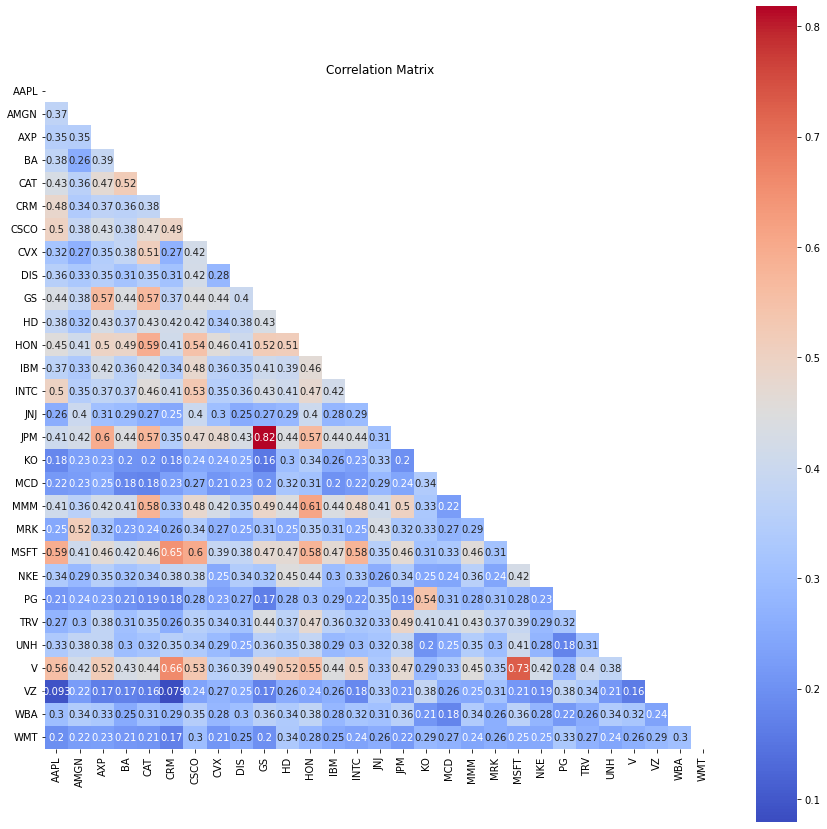

In [9]:
# Plot the Correlation matrix
mask = np.zeros_like(df_dow_returns.corr())
mask[np.triu_indices_from(mask)]=True

plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(df_dow_returns.corr(), annot=True, square=True,\
            mask=mask, #vmin=0, vmax=1,
            cmap='coolwarm');

We can see that there is positive correlation of the daily returns between the stocks, which indicates that the returns can be represented by fewer variables.

## Data Preparation

In [10]:
# Final check for any null values and removing the null values
print('Null Values =', df_dow_returns.isnull().values.any())

Null Values = False


In [11]:
# Code to remove any tickers with more than n% of missing data
n = 0.3

# Find the percentage of null values, from biggest to smallest
pct_of_missing = df_dow_returns.isnull().mean().sort_values(ascending=False)

# Returns the index of all the columns with high pct of null values
drop_list = sorted(list(pct_of_missing[pct_of_missing > n].index))

# Drop the columns
df_dow_returns.drop(labels=drop_list, axis=1, inplace=True)
df_dow_returns.shape

(1004, 29)

In [12]:
df_dow_returns.describe()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
count,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,...,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000
mean,0.001200,0.000622,0.000753,0.001077,0.001037,0.000907,0.000805,0.000541,0.000463,0.000433,...,0.000738,0.001229,0.000651,0.000634,0.000363,0.001070,0.001012,0.000526,-0.000136,0.000832
std,0.015341,0.013764,0.012795,0.016391,0.017058,0.017809,0.014096,0.012909,0.012078,0.015216,...,0.011888,0.013817,0.015008,0.009788,0.010626,0.013119,0.012562,0.010958,0.015019,0.012140
min,-0.099607,-0.095846,-0.121009,-0.089290,-0.091261,-0.129315,-0.086149,-0.055666,-0.052949,-0.074556,...,-0.060611,-0.071710,-0.070505,-0.040045,-0.082869,-0.051822,-0.052697,-0.046810,-0.128052,-0.101832
25%,-0.005496,-0.005924,-0.004904,-0.007124,-0.007256,-0.006329,-0.005470,-0.005760,-0.005456,-0.007453,...,-0.005397,-0.004891,-0.006873,-0.004224,-0.004726,-0.005670,-0.004639,-0.005326,-0.007029,-0.004742
50%,0.000976,0.000774,0.001007,0.001350,0.000592,0.001035,0.001270,0.000776,0.000241,0.000481,...,0.000626,0.001044,0.000573,0.000623,0.000736,0.000957,0.001695,0.000733,0.000879,0.001024
75%,0.008896,0.007818,0.007233,0.009946,0.010091,0.009585,0.007691,0.007186,0.006235,0.008893,...,0.007025,0.008169,0.008917,0.005695,0.006169,0.007529,0.007704,0.006675,0.007848,0.006596
max,0.070422,0.059494,0.090286,0.098795,0.078608,0.110365,0.096402,0.063373,0.115437,0.095436,...,0.104080,0.075706,0.111297,0.087986,0.049588,0.081599,0.074427,0.076802,0.057648,0.108984


In [13]:
# Remove outliers that is 3 standard deviations away so that the PCA can work
# If there is an outlier (defined as 3 times StdDev of returns, then remove entire row)
no_outliers_mask = df_dow_returns.apply(lambda x :(x-x.mean()).abs()<(3*x.std())).all(1)

# Dow returns with no outliers
df_dow_returns = df_dow_returns[no_outliers_mask]

In [14]:
df_dow_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 775 entries, 2016-01-05 00:00:00-05:00 to 2019-12-30 00:00:00-05:00
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    775 non-null    float64
 1   AMGN    775 non-null    float64
 2   AXP     775 non-null    float64
 3   BA      775 non-null    float64
 4   CAT     775 non-null    float64
 5   CRM     775 non-null    float64
 6   CSCO    775 non-null    float64
 7   CVX     775 non-null    float64
 8   DIS     775 non-null    float64
 9   GS      775 non-null    float64
 10  HD      775 non-null    float64
 11  HON     775 non-null    float64
 12  IBM     775 non-null    float64
 13  INTC    775 non-null    float64
 14  JNJ     775 non-null    float64
 15  JPM     775 non-null    float64
 16  KO      775 non-null    float64
 17  MCD     775 non-null    float64
 18  MMM     775 non-null    float64
 19  MRK     775 non-null    float64
 20  MSFT    775 non-null    flo

In [15]:
# Instantiate StandardScaler
ss = StandardScaler()

# Scale the Returns data
df_dow_returns_sc = ss.fit_transform(df_dow_returns)

# Transform the array into a dataframe
df_dow_returns_sc = pd.DataFrame(df_dow_returns_sc, columns=df_dow_returns.columns, index=df_dow_returns.index)

In [16]:
# Check that all the returns have been scaled appropriately
df_dow_returns_sc.head()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05 00:00:00-05:00,-2.269522,-0.209554,-1.802114,0.179575,-0.838290,0.211757,-0.582272,0.727721,-2.356463,-1.480048,...,1.231045,0.254118,1.070637,0.286893,0.409473,0.044544,0.612769,1.384419,-2.351537,2.530109
2016-01-08 00:00:00-05:00,0.310375,-1.501838,-0.483197,-1.863803,-0.818251,-1.206214,-2.533313,-1.097070,-0.381390,-0.399572,...,-1.928747,0.108095,-1.461626,-2.192694,-0.673184,-1.778317,-1.482476,-1.195572,-0.196298,-2.671378
2016-01-11 00:00:00-05:00,1.237463,-1.990053,0.595024,-0.000976,-2.162419,-0.173364,1.760787,-1.649828,0.653082,0.842841,...,0.226975,-0.247437,0.868054,1.078531,0.779833,-0.637977,1.323827,0.511610,-0.099879,1.075198
2016-01-12 00:00:00-05:00,1.094683,1.861781,0.471234,0.872492,0.069667,1.194955,0.160599,1.535486,1.620399,-0.068521,...,0.931542,0.704851,0.450774,-0.406575,1.223455,2.197559,1.017264,-0.516727,0.791451,-1.158965
2016-01-19 00:00:00-05:00,-0.550493,-0.108788,-0.592480,0.131110,-1.097677,-0.185703,0.793766,-2.526250,-0.017580,0.583394,...,0.288959,-1.014972,1.005938,2.934959,0.623339,2.754189,-0.827717,0.962990,0.770519,1.016237


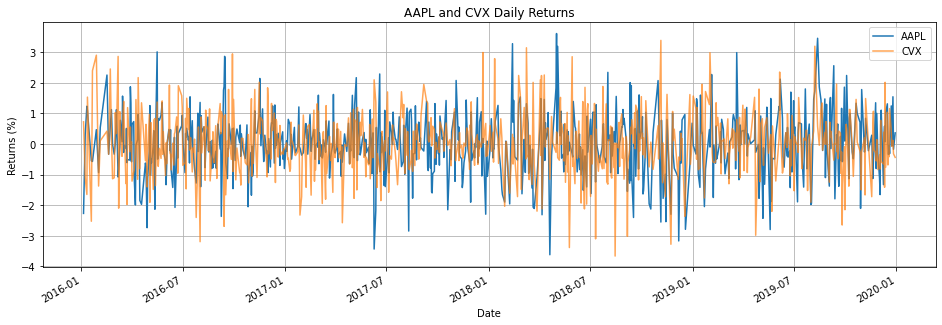

In [17]:
# Visualizing linear returns for two of the stocks
plt.figure(figsize=(16, 5))
plt.title("AAPL and CVX Daily Returns")
plt.ylabel("Returns (%)")

# Plot for AAPL (Blue) and CVX (Light Orange)
df_dow_returns_sc['AAPL'].plot()
df_dow_returns_sc['CVX'].plot(alpha=0.7)

plt.grid(True)
plt.legend()
plt.show();

## Modelling

In [18]:
# Dividing the dataset into training and testing sets
# Define the train size
train_size = 0.8

# Get the total number of training rows
numTrainRows = int(len(df_dow_returns_sc) * train_size)

# Split the scaled dataset into train and test based on above
X_train_sc = df_dow_returns_sc[:numTrainRows]
X_test_sc = df_dow_returns_sc[numTrainRows:]

# Split the original dataset (before scaling) into train and test
X_train = df_dow_returns[:numTrainRows]
X_test = df_dow_returns[numTrainRows:]

## Applying PCA to the training data

In [19]:
# Instantiate PCA
pca = PCA(random_state=42)
#PrincipalComponent=pca.fit(X_train)

In [20]:
# Fit PCA on training data
pca.fit(X_train_sc)

PCA(random_state=42)

In [21]:
# Transform PCA on training data
Z_train = pca.transform(X_train_sc)

In [22]:
pd.DataFrame(Z_train).describe()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
count,6.200000e+02,6.200000e+02,6.200000e+02,6.200000e+02,6.200000e+02,6.200000e+02,6.200000e+02,6.200000e+02,6.200000e+02,6.200000e+02,...,6.200000e+02,6.200000e+02,6.200000e+02,6.200000e+02,6.200000e+02,6.200000e+02,6.200000e+02,6.200000e+02,6.200000e+02,6.200000e+02
mean,2.292073e-17,-6.088320e-18,-1.898123e-17,-4.888563e-17,-3.581365e-19,3.115787e-17,-8.651234e-18,1.432546e-17,2.686023e-18,-1.414639e-17,...,-3.133694e-18,-3.393343e-17,-1.163943e-17,-2.059285e-18,-5.081061e-18,-7.520866e-18,1.719055e-17,-2.301027e-17,8.595275e-18,1.163943e-17
std,3.031155e+00,1.503660e+00,1.263542e+00,1.096699e+00,1.051875e+00,9.888100e-01,9.723080e-01,9.416715e-01,9.084429e-01,8.565597e-01,...,6.717406e-01,6.700768e-01,6.529783e-01,6.455694e-01,6.178198e-01,5.951975e-01,5.796163e-01,5.554567e-01,5.422128e-01,4.317637e-01
min,-1.104481e+01,-4.708971e+00,-3.411149e+00,-3.816232e+00,-3.131988e+00,-3.068238e+00,-3.547289e+00,-3.068754e+00,-2.435990e+00,-2.647955e+00,...,-2.031371e+00,-1.960338e+00,-2.428919e+00,-1.733199e+00,-2.050856e+00,-1.745345e+00,-2.155361e+00,-1.630209e+00,-1.565403e+00,-1.275860e+00
25%,-1.506248e+00,-9.546956e-01,-8.616716e-01,-6.718607e-01,-6.968178e-01,-5.782209e-01,-5.963222e-01,-6.194797e-01,-5.728955e-01,-5.499260e-01,...,-4.040060e-01,-3.817390e-01,-4.377606e-01,-4.192651e-01,-4.149435e-01,-3.886752e-01,-3.689691e-01,-3.608326e-01,-3.295656e-01,-2.886657e-01
50%,1.615389e-01,3.900471e-02,-4.689719e-03,6.092383e-03,-3.748994e-02,-1.955286e-02,-2.091268e-02,-1.699423e-02,-3.514125e-02,3.005288e-02,...,-2.994589e-03,-3.905633e-02,3.773509e-03,2.821219e-03,-2.352592e-03,-1.421993e-02,1.218569e-02,2.519056e-02,-8.745882e-03,1.087143e-02
75%,1.468788e+00,8.487364e-01,7.282956e-01,6.320047e-01,6.543264e-01,6.428258e-01,5.854925e-01,5.948600e-01,5.468449e-01,5.311939e-01,...,4.356068e-01,4.089146e-01,4.152562e-01,3.910410e-01,4.057067e-01,3.842388e-01,3.743772e-01,3.694093e-01,2.958376e-01,2.827218e-01
max,1.290593e+01,5.405365e+00,6.476561e+00,5.349223e+00,3.681293e+00,3.540902e+00,4.855678e+00,4.372171e+00,3.702909e+00,3.145512e+00,...,2.681082e+00,2.658551e+00,2.518658e+00,3.011234e+00,2.386983e+00,1.956976e+00,2.277254e+00,1.803107e+00,2.084175e+00,1.340139e+00


,Cumulative Explained Variance
0,32.00%
1,39.87%
2,45.43%
3,49.62%
4,53.47%
5,56.87%
6,60.17%
7,63.25%
8,66.13%
9,68.68%


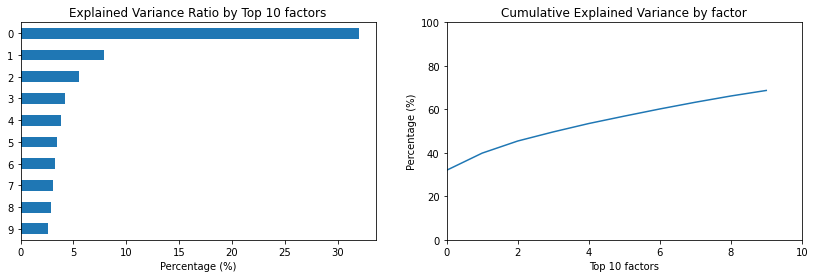

In [23]:
# Pull the explained variance attribute
var_exp = pca.explained_variance_ratio_

# Define number of Eigenvalues to display in plots and dataframe below
NumEigenvalues=10

# Create Subplots
fig, axes = plt.subplots(ncols=2, figsize=(14,4))

# Sort the explained variance attributes and plot on graph
series1 = pd.Series(var_exp[:NumEigenvalues]).sort_values()*100
series1.plot.barh(ylim=(0, NumEigenvalues),
                  title=f'Explained Variance Ratio by Top {NumEigenvalues} factors',
                  ax=axes[0],);
axes[0].set(xlabel='Percentage (%)')

# Plot the Cumulative Explained Variance
Series2 = pd.Series(var_exp[:NumEigenvalues]).cumsum()*100
Series2.plot(ylim=(0,100), xlim=(0, NumEigenvalues), ax=axes[1], 
             title='Cumulative Explained Variance by factor');
axes[1].set(xlabel=f'Top {NumEigenvalues} factors')
axes[1].set(ylabel='Percentage (%)')

# Cumulative explained variance in a dataframe, display number of Eigenvalues
pd.Series(np.cumsum(var_exp)).to_frame('Cumulative Explained Variance').\
head(NumEigenvalues).style.format('{:,.2%}'.format)

The most important factor (Principal Component 0) explains about 32% of the daily return variation. This most dominant component is usually interpreted as the market or systemic factor.

We want to look at the individual components more closely and these may be less interpretable than the original features. We can look at the weight of the factors to assess any intuitive themes relative to the 29 stocks.

We do this by constructing five portfolios, defining the weight of each stocks as each of the five principal components. Then we create a scatterplot to visualize the weight of each stock at each chose principal component.

In [24]:
# View the PCA Components
pca.components_

array([[-1.66555370e-01, -2.01491772e-01, -2.18995902e-01,
        -1.82412363e-01, -2.09449487e-01, -1.57770162e-01,
        -2.23131513e-01, -1.56779122e-01, -1.46695490e-01,
        -2.02429230e-01, -1.88504479e-01, -2.21619525e-01,
        -2.23592209e-01, -2.11929131e-01, -1.77674180e-01,
        -2.12755689e-01, -1.50799268e-01, -1.39414589e-01,
        -2.19500105e-01, -1.69041790e-01, -2.24005574e-01,
        -1.47699486e-01, -1.52139001e-01, -1.97248085e-01,
        -1.80066065e-01, -2.17606537e-01, -1.35028432e-01,
        -1.47450441e-01, -1.25229747e-01],
       [ 1.65468822e-01, -9.54937205e-02,  1.49112689e-01,
         1.17044308e-01,  1.89784574e-01,  2.16827001e-01,
         9.35984057e-02,  5.78148989e-02, -2.54748584e-02,
         2.81156505e-01, -2.50021237e-02,  6.93838242e-02,
        -1.55372491e-02,  7.90709225e-02, -2.81317989e-01,
         2.47657742e-01, -3.35997134e-01, -1.55557097e-01,
        -3.53678194e-02, -2.22469420e-01,  1.16483033e-01,
         1.26

In [25]:
# Find the Principal Component weights for each PC
def pc_weights():
    
    # Create a DataFrame for the weights
    weights = pd.DataFrame()

    # Store the weights of each Pricipal Component in a column
    for i in range(len(pca.components_)):
        weights[f"weights_{i}"] = pca.components_[i] / sum(pca.components_[i])

    weights = weights.values.T
    return weights

In [26]:
# Over here we have a dataframe, where the rows represent each Eigenvector,
# and columns represent the weight of each stock. Each row sums to 1.
weights = pc_weights()
pd.DataFrame(weights)

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.031384,0.037967,0.041265,0.034372,0.039467,0.029729,0.042045,0.029542,0.027642,0.038144,...,0.031853,0.042209,0.027831,0.028668,0.037167,0.033930,0.041004,0.025443,0.027784,0.023597
1,-0.297945,0.171947,-0.268494,-0.210751,-0.341728,-0.390421,-0.168534,-0.104102,0.045870,-0.506254,...,0.400581,-0.209741,-0.022846,0.586287,0.184780,0.127373,-0.308302,0.577514,0.306092,0.613598
2,3.955488,1.644120,-1.931673,-1.651924,-3.045624,5.655838,2.077699,-4.607012,-0.310492,-3.943254,...,0.718654,4.657957,1.850548,0.645016,-3.396140,-0.299470,4.629108,-1.705732,0.281757,-0.271997
3,-0.621751,-17.131641,-4.450079,9.640646,8.431078,-2.347046,-2.411698,5.539579,-6.706714,-8.805354,...,-15.682001,2.848341,6.325024,5.197714,1.146998,-6.396190,2.631145,-1.981371,-14.399690,3.720887
4,-0.018007,-0.766502,0.495209,-0.307254,-0.522730,-0.138106,-0.017582,-0.704620,1.613054,0.172737,...,-1.404073,0.034453,1.392853,-0.164472,0.107322,-0.261692,-0.085509,0.642972,1.141686,1.691933
5,-6.892874,-1.616829,9.819549,1.474732,-12.690030,-1.179236,-7.052054,-18.986328,-13.142487,9.764105,...,3.801020,-1.659597,14.710088,-6.217024,8.968224,11.245995,3.673497,-12.453078,-2.259628,5.676247
6,2.008948,-43.103261,16.939248,-23.438870,-24.840823,13.531760,0.328781,3.792721,-20.992360,18.597938,...,-17.975080,27.530790,-55.336266,9.295034,30.073727,-3.083898,12.874039,20.567335,16.376001,1.470561
7,-0.929015,0.121095,0.389668,-0.393819,-0.458702,0.231802,0.610488,1.981488,-0.029112,-0.058484,...,1.206810,0.109552,0.843142,-1.240567,-1.365053,-0.644662,0.564139,2.331636,-1.604458,0.208732
8,5.752798,1.525222,-2.287550,3.412401,1.835841,-3.441709,1.586678,1.167940,-3.353427,-1.151460,...,-0.292785,-0.273237,-5.937513,-4.554687,-2.547020,3.964129,-1.162069,-3.094370,0.822851,13.007499
9,0.904379,0.347166,-0.869045,0.857474,0.083200,-0.734746,-0.191203,-1.124836,3.330429,0.134638,...,-0.439161,-0.042726,-0.180126,-0.674399,0.302585,1.164172,-0.923699,0.767183,-0.707126,-1.416003


What is Explained Variance? 
- It is a statistical measure of how much variation in a dataset can be attributed to each pricipal component (eigenvector).
- Tells us how much information (variance) is captured by each PC, calculated by the eigenvalue of the PC over the sum of eigenvalues of all PC.
- As per below, we can see the first PC explaining the most variance, and therefore the most important.

In [27]:
# Display the Explained Variance
pca.explained_variance_

array([9.1879015 , 2.26099245, 1.59653894, 1.20274887, 1.10644183,
       0.97774526, 0.94538291, 0.88674523, 0.82526851, 0.73369459,
       0.7030723 , 0.67409233, 0.64914412, 0.62950647, 0.60273886,
       0.58531618, 0.55198642, 0.50295822, 0.48992954, 0.45123545,
       0.44900289, 0.42638061, 0.41675981, 0.38170131, 0.35426011,
       0.33595508, 0.30853217, 0.29399469, 0.18641991])

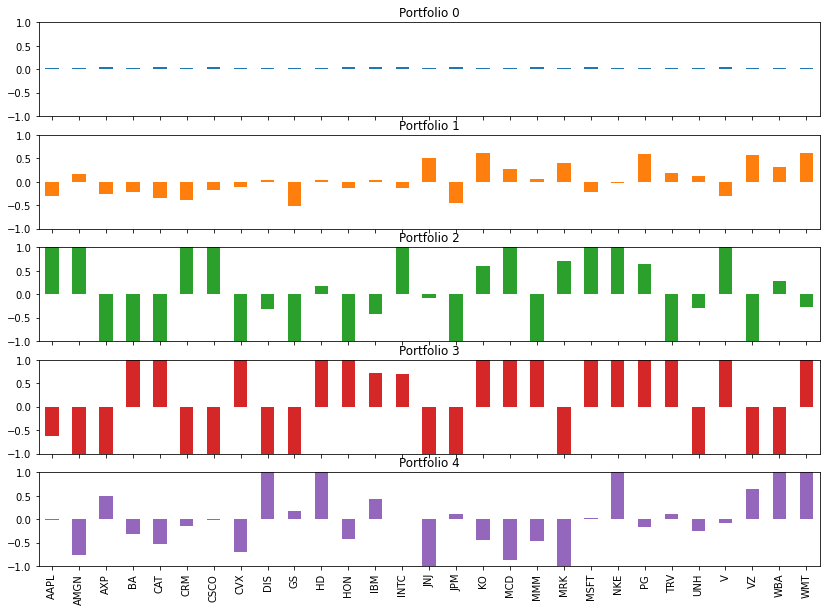

In [28]:
# Define the number of PC/Eigenvectors we want to display
numPC = 5

# Create n portfolios using the Principal Components
portfolios = pd.DataFrame(pca.components_[:numPC], 
                             columns=df_dow_returns_sc.columns)

# Converting the values of each PC to weights
eigen_portfolios = portfolios.div(portfolios.sum(axis=1), axis=0)

# Setting the Index of the dataframe
eigen_portfolios.index = [f'Portfolio {i}' for i in range(numPC)]

# Plot bar charts
eigen_portfolios.T.plot.bar(subplots=True, layout=(int(numPC),1),
                            figsize=(14,10), legend=False,
                            sharey=True, ylim=(-1,1));

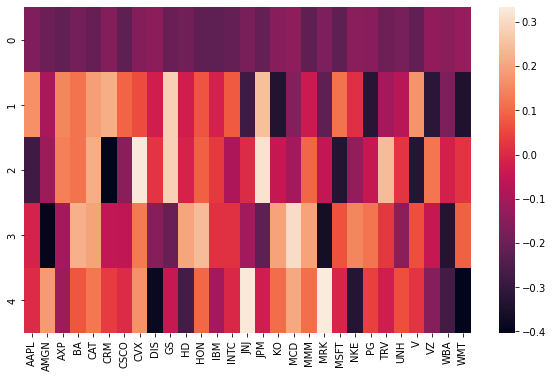

In [29]:
# Presenting the above chart in another way
plt.figure(figsize=(10,6))
sns.heatmap(portfolios);

How to intepret:
- Each portfolio represents an independent risk factor.
- All our stocks are US stocks, and typically the principal portfolio with the largest variance represents a systematic risk factor that cannot be diversified away ("market risk")
- Weights are distributed evenly at the top portfolio and represents about 32% of the variance.
- Other portfolios usually correspond to sector or industry factors
    - Portfolio 1: We see the dark coloured one (JNJ, KO, PG, VZ, WMT) possibly belonging to consumer goods
    - Portfolio 2: AAPL, CRM, MSFT, V likely have high weights on technology
- If we expand asset universe to broad, global investments, we may be able to identity factors for equity risk, interest rate risk, commodities, geography etc.

## How to find the best portfolio

The Sharpe ratio is a risk-adjusted performance that explains the annualized returns against the volatility of a portfolio. Higher Sharpe ratio indicats a higher return and lower volatility. We will use it to compare and evaluate performances of different portfolios.

In [30]:
# Sharpe Ratio, used to find the performance of a single portfolio
# Annualize the ratio by taking annualized return over annualized volatility
def sharpe_ratio(returns, days_per_year=252):
    
    # Number of rows over number of days will give the years as a float number
    n_years = returns.shape[0]/days_per_year
    
    # To annualize returns
    annualized_return = np.power(np.prod(1+returns), (1/n_years)) - 1
    
    # To annualize volatility
    annualized_vol = returns.std() * np.sqrt(days_per_year)
    
    annualized_sharpe = annualized_return / annualized_vol

    return annualized_return, annualized_vol, annualized_sharpe

We need to use a loop to compute the weights for each portfolio, then use the Sharpe ratio function to find which has the best performance.

In [31]:
def find_highest_sharpe_port():
    
    # Principal Components
    pcs = pca.components_
    
    # Number of portfolios will be equal to the number of PCs
    numPorts = len(pcs)
    
    # Instantiate zeros and arrays of zeros first
    annual_returns = np.array([0.] * numPorts)
    annual_vol = np.array([0.] * numPorts)
    annual_sharpe = np.array([0.] * numPorts)
    highest_sharpe = 0
    
    stock_tickers = df_dow_returns_sc.columns
    n_tickers = len(stock_tickers)

    for i in range(numPorts):
        weights = pcs[i]/sum(pcs[i])
        
        # Create a dataframe of portfolios
        # Index is the stock tickers, columns are the weight in %
        eigen_port_i = pd.DataFrame(data={'weights': weights.squeeze()*100},
                                    index=stock_tickers)
        
        # For the portfolio, sort out the stocks with higher weights first
        eigen_port_i.sort_values(by='weights', ascending=False, inplace=True)
    
        
        # Dot product the individual stock returns (620x29) x weights (29x1)
        # To get the daily portfolio returns
        eigen_port_i_returns = np.dot(X_train.loc[:, eigen_port_i.index], weights)
        eigen_port_i_returns = pd.Series(eigen_port_i_returns.squeeze(),
                                         index=X_train.index)
        
        # Pass the returns into the Sharpe ratio function defined earlier
        exp_ret, vol, sharpe = sharpe_ratio(eigen_port_i_returns)
        
        # Record the values for expected returns, vol, and Sharpe for all portfolios
        annual_returns[i] = exp_ret
        annual_vol[i] = vol
        annual_sharpe[i] = sharpe
        
        # Just in case any numbers are null or inf
        annual_sharpe = np.nan_to_num(annual_sharpe)
    
    # Finding the portfolio with highest Sharpe ratio, returns the index
    highest_sharpe = np.argmax(annual_sharpe)
    
    print('Eigen Portfolio #%d has the highest Sharpe Ratio. \
          \nReturn = %.2f%%, Vol = %.2f%%, Sharpe = %.2f \n' \
          %(highest_sharpe, annual_returns[highest_sharpe]*100,
            annual_vol[highest_sharpe]*100, annual_sharpe[highest_sharpe]))
    
    # Plot all the Sharpe Ratios of the different Eigen-portfolios
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    ax.plot(annual_sharpe, linewidth=3)
    ax.set_title('Sharpe Ratio of Portfolios')
    ax.set_ylabel('Sharpe Ratio')
    ax.set_xlabel('Portfolio Number')
    
    # Save all the results in a dataframe
    results = pd.DataFrame(data={'Return': annual_returns,
                                 'Vol': annual_vol, 
                                 'Sharpe': annual_sharpe})
    results.dropna(inplace=True)
    results.sort_values(by=['Sharpe'], ascending=False, inplace=True)
    print("Top 5 portfolios, sorted by Sharpe\n")
    print(results.head(5))

    plt.show();

Eigen Portfolio #0 has the highest Sharpe Ratio.           
Return = 33.88%, Vol = 9.04%, Sharpe = 3.75 

Top 5 portfolios, sorted by Sharpe

      Return       Vol    Sharpe
0   0.338830  0.090368  3.749436
19  1.494725  0.949245  1.574646
26  1.237802  0.872258  1.419078
1   0.367524  0.344381  1.067204
16  0.603939  0.701469  0.860964


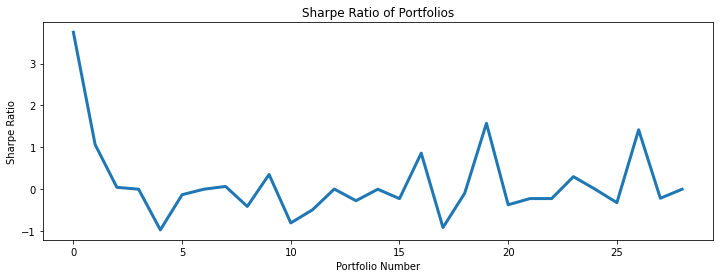

In [32]:
find_highest_sharpe_port()

Portfolio #0 seems to be the best performing one, with good returns and low volatility. We want to examine weightage of the portfolio to see what it consists of, and do some backtesting on the test set to see the results.

In [33]:
# Get all the stocks
stock_tickers = df_dow_returns_sc.columns

# Instantiate an empty DataFrame of a single portfolio
single_portfolio = pd.DataFrame()

# Define function to plot a single Eigen-portfolio composition. 
# Weights is an array of all the PC weights. Rows sum to 1.

def plotPortComposition(weights_of_PC, plot=False):
    
    # Create dataframe of stocktickers as rows and weights as columns, then sort
    single_portfolio = pd.DataFrame(data ={'weights': weights_of_PC.squeeze()*100}, index = stock_tickers) 
    single_portfolio.sort_values(by=['weights'], ascending=False, inplace=True)
    
    if plot:
        print('Sum of weights of current Eigen-Portfolio: %.2f' % np.sum(single_portfolio))
        
        single_portfolio.plot(title='Current Eigen-Portfolio Weights', 
                              figsize=(12,6),
                              xticks=range(0, len(stock_tickers), 1), 
                              rot=45,        
                              linewidth=3)
                      
        plt.show()
        
    # returns the dataframe of stock component weights    
    return single_portfolio

Sum of weights of current Eigen-Portfolio: 100.00


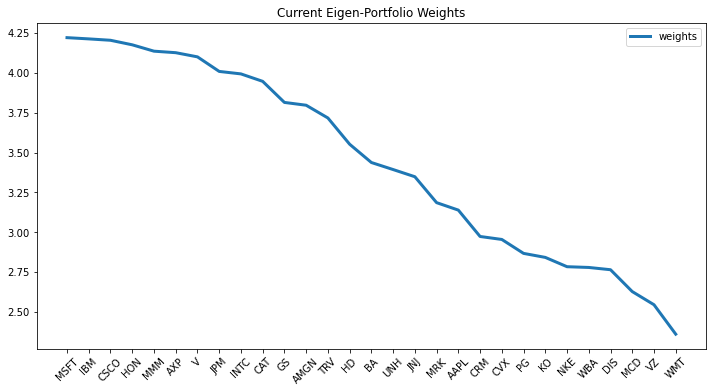

,weights
MSFT,4.220934
IBM,4.213145
CSCO,4.204464
HON,4.175973
MMM,4.136037
AXP,4.126537
V,4.100357
JPM,4.008952
INTC,3.993377
CAT,3.946654


In [34]:
# Weights are stored in arrays. weight[0] is the first PC's weight.
plotPortComposition(weights[0], plot=True)

In [35]:
# Plots Principal Component returns against Real Returns

# Doing the backtesting of a single portfolio (in this case the eigen portfolio) against a equal-weighted index
# Takes in an array of weights
def backtestPort(weights_of_PC, test_time_series):
   
    # Create dataframe of stocktickers as rows and weights as columns, then sort.
    # As per previous function
    eigen_port_i = pd.DataFrame(data ={'weights': weights_of_PC.squeeze()}, index = stock_tickers)
    eigen_port_i.sort_values(by=['weights'], ascending=False, inplace=True)    

    # Portfolio returns would test_time_series (rows,stocks) x weights (stocks,)
    eigen_port_returns = np.dot(test_time_series.loc[:, eigen_port_i.index], weights_of_PC)
    
    # Transform the daily returns into a series, with dates as the index
    eigen_port_returns = pd.Series(eigen_port_returns.squeeze(),
                                   index=test_time_series.index)
    
    # Returns the Sharpe Ratio of the tested portfolio                               
    returns, vol, sharpe = sharpe_ratio(eigen_port_returns)  
    
    print('Current Eigen-Portfolio: Return = %.2f%%, Volatility = %.2f%%, Sharpe = %.2f'\
          %(returns*100, vol*100, sharpe))
    
    # Calculate the equal weighted portfolio below here
    numStocks = len(pca.components_)
    
    # Returns the daily equal weighted return
    equal_weight_return = (test_time_series * (1/numStocks)).sum(axis=1)
    
    returns1, vol1, sharpe1 = sharpe_ratio(equal_weight_return)  
    print('Equal-weighted Index: Return = %.2f%%, Volatility = %.2f%%, Sharpe = %.2f'\
          %(returns1*100, vol1*100, sharpe1))
    
    # Sets up a Dataframe of the EigenPort returns vs Equal Weight Port returns
    df_returns = pd.DataFrame({'Eigen-Porfolio Returns': eigen_port_returns,
                               'Equal Weight Index': equal_weight_return}, 
                              index=test_time_series.index)
    
    # Cumprod will find the index values of both portfolios from start to end
    np.cumprod(df_returns + 1).plot(title='Returns of the equal weighted index vs. Eigen Portfolio',
                                    figsize=(12,6), linewidth=3)
    plt.show();

We will backtest from end Feb 2019 till end of year 2019, to get a sense of how the portfolio might do if we had allocated as per the some of the better Eigen-portfolios vs the worst one.

Current Eigen-Portfolio: Return = 40.82%, Volatility = 9.29%, Sharpe = 4.39
Equal-weighted Index: Return = 41.67%, Volatility = 9.09%, Sharpe = 4.58


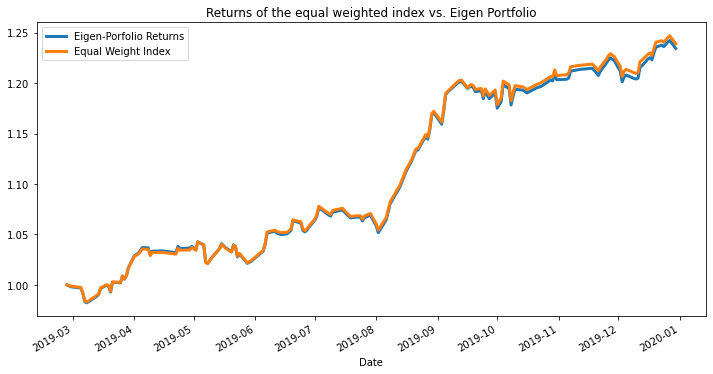

Current Eigen-Portfolio: Return = -82.91%, Volatility = 97.51%, Sharpe = -0.85
Equal-weighted Index: Return = 41.67%, Volatility = 9.09%, Sharpe = 4.58


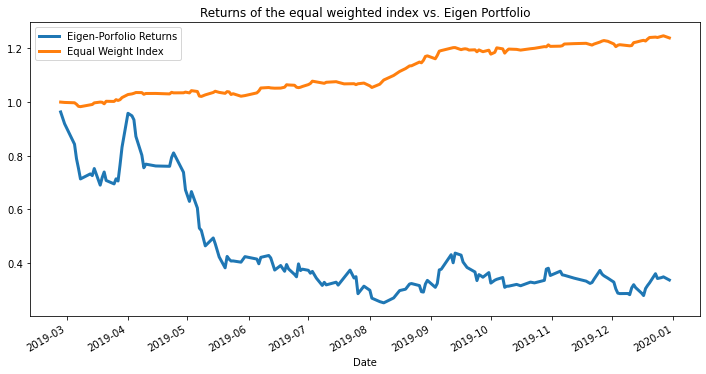

Current Eigen-Portfolio: Return = -75.96%, Volatility = 91.86%, Sharpe = -0.83
Equal-weighted Index: Return = 41.67%, Volatility = 9.09%, Sharpe = 4.58


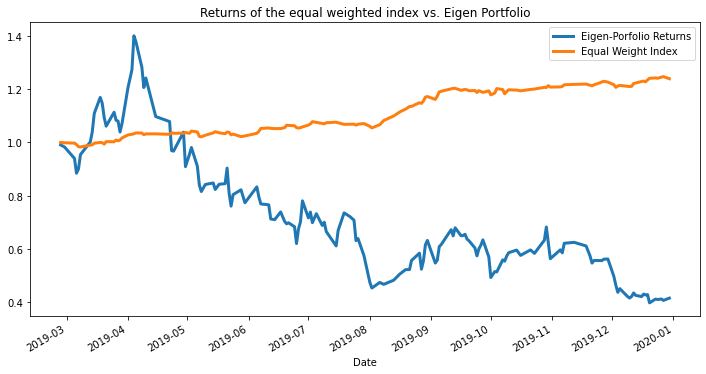

Current Eigen-Portfolio: Return = 151.28%, Volatility = 61.48%, Sharpe = 2.46
Equal-weighted Index: Return = 41.67%, Volatility = 9.09%, Sharpe = 4.58


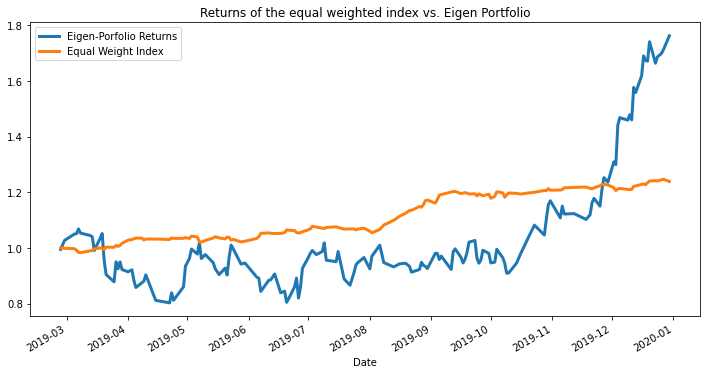

In [36]:
# Plot the three best portfolios, and the worst performing one
backtestPort(weights[0], X_test)
backtestPort(weights[19], X_test)
backtestPort(weights[26], X_test)
backtestPort(weights[4], X_test)

# Evaluation of results

In [37]:
# We can see why the performance was so bad.
plotPortComposition(weights[4], plot=False)

,weights
WMT,169.193315
DIS,161.305380
NKE,139.285307
WBA,114.168558
HD,113.445651
VZ,64.297189
AXP,49.520937
IBM,42.919158
GS,17.273698
TRV,10.732197


In [38]:
df_weights4 = plotPortComposition(weights[4], plot=False)

In [49]:
portfolios

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
0,-0.166555,-0.201492,-0.218996,-0.182412,-0.209449,-0.157770,-0.223132,-0.156779,-0.146695,-0.202429,...,-0.169042,-0.224006,-0.147699,-0.152139,-0.197248,-0.180066,-0.217607,-0.135028,-0.147450,-0.125230
1,0.165469,-0.095494,0.149113,0.117044,0.189785,0.216827,0.093598,0.057815,-0.025475,0.281157,...,-0.222469,0.116483,0.012688,-0.325604,-0.102620,-0.070739,0.171220,-0.320732,-0.169993,-0.340772
2,-0.282248,-0.117318,0.137837,0.117875,0.217324,-0.403579,-0.148257,0.328739,0.022155,0.281375,...,-0.051280,-0.332374,-0.132048,-0.046026,0.242335,0.021369,-0.330315,0.121714,-0.020105,0.019409
3,-0.014438,-0.397811,-0.103335,0.223864,0.195777,-0.054500,-0.056002,0.128634,-0.155735,-0.204468,...,-0.364149,0.066141,0.146872,0.120695,0.026634,-0.148525,0.061097,-0.046009,-0.334373,0.086402
4,0.004283,0.182325,-0.117794,0.073085,0.124340,0.032851,0.004182,0.167605,-0.383691,-0.041088,...,0.333982,-0.008195,-0.331313,0.039122,-0.025528,0.062248,0.020340,-0.152941,-0.271568,-0.402454
